In [1]:
from datetime import datetime, timedelta

# the internal sos server web address
mySosUrl = "http://ltom-loggernet.domenis.ut.ee:8081/sos/service"

# actual date and time NOW
dateNow = datetime.now()
# we can add and substract time periods from to calculate new dates
timeDelta = timedelta(days=3)
# a date and time that 3 days before NOW
datetimeDaysBack = dateNow - timeDelta

# we fill this structure to fill out the underlying XML request
requestParameter = {'arg1': 'temperature-sensor', 'arg2':datetimeDaysBack.isoformat(), 'arg3':dateNow.isoformat()}

myRequestXml = """<?xml version="1.0" encoding="UTF-8"?>
<sos:GetObservation
    xmlns:sos="http://www.opengis.net/sos/2.0"
    xmlns:fes="http://www.opengis.net/fes/2.0"
    xmlns:gml="http://www.opengis.net/gml/3.2"
    xmlns:swe="http://www.opengis.net/swe/2.0"
    xmlns:xlink="http://www.w3.org/1999/xlink"
    xmlns:swes="http://www.opengis.net/swes/2.0"
    xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" service="SOS" version="2.0.0" xsi:schemaLocation="http://www.opengis.net/sos/2.0 http://schemas.opengis.net/sos/2.0/sos.xsd">

    <sos:procedure>{arg1}</sos:procedure>

    <sos:temporalFilter>
        <fes:During>
            <fes:ValueReference>phenomenonTime</fes:ValueReference>
            <gml:TimePeriod gml:id="tp_1">
                <gml:beginPosition>{arg2}</gml:beginPosition>
                <gml:endPosition>{arg3}</gml:endPosition>
            </gml:TimePeriod>
        </fes:During>
    </sos:temporalFilter>
    <sos:responseFormat>http://www.opengis.net/om/2.0</sos:responseFormat>
</sos:GetObservation>""".format(**requestParameter)



In [2]:
print(myRequestXml)

<?xml version="1.0" encoding="UTF-8"?>
<sos:GetObservation
    xmlns:sos="http://www.opengis.net/sos/2.0"
    xmlns:fes="http://www.opengis.net/fes/2.0"
    xmlns:gml="http://www.opengis.net/gml/3.2"
    xmlns:swe="http://www.opengis.net/swe/2.0"
    xmlns:xlink="http://www.w3.org/1999/xlink"
    xmlns:swes="http://www.opengis.net/swes/2.0"
    xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" service="SOS" version="2.0.0" xsi:schemaLocation="http://www.opengis.net/sos/2.0 http://schemas.opengis.net/sos/2.0/sos.xsd">

    <sos:procedure>temperature-sensor</sos:procedure>

    <sos:temporalFilter>
        <fes:During>
            <fes:ValueReference>phenomenonTime</fes:ValueReference>
            <gml:TimePeriod gml:id="tp_1">
                <gml:beginPosition>2017-12-12T16:04:26.509065</gml:beginPosition>
                <gml:endPosition>2017-12-15T16:04:26.509065</gml:endPosition>
            </gml:TimePeriod>
        </fes:During>
    </sos:temporalFilter>
    <sos:responseForma

In [3]:
import urllib.request
import urllib.parse

# we have to convert the text string into binary bits and bytes
data = bytes( myRequestXml,'utf-8')

# and now we fire the request to the server
req = urllib.request.Request(url=mySosUrl, 
                      data=data, 
                      headers={'Content-Type': 'application/xml'})

# if successful we can now read out the returned data with the observations from the response data stream
with urllib.request.urlopen(req) as response:
    responseXmlBody = response.read().decode('utf-8')

In [4]:
print(responseXmlBody)

<?xml version="1.0" encoding="UTF-8"?>
<sos:GetObservationResponse xmlns:sos="http://www.opengis.net/sos/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:om="http://www.opengis.net/om/2.0" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:xlink="http://www.w3.org/1999/xlink" xsi:schemaLocation="http://www.opengis.net/sos/2.0 http://schemas.opengis.net/sos/2.0/sosGetObservation.xsd http://www.opengis.net/om/2.0 http://schemas.opengis.net/om/2.0/observation.xsd http://www.opengis.net/gml/3.2 http://schemas.opengis.net/gml/3.2.1/gml.xsd">
  <sos:observationData>
    <om:OM_Observation gml:id="o_1513096200">
      <gml:identifier codeSpace="http://geograafia.ut.ee/soontaga">15788-2017</gml:identifier>
      <om:type xlink:href="http://www.opengis.net/def/observationType/OGC-OM/2.0/OM_Measurement"/>
      <om:phenomenonTime>
        <gml:TimeInstant gml:id="phenomenonTime_1513096200">
          <gml:timePosition>2017-12-12T16:30:00.000Z</gml:timePosition>
        </gml:TimeIn

In [5]:
import xml.etree.ElementTree as ET

# here now a bit of XML manipulation magic to read out the data and time of each observation and the corresponding temperate value at that point in time
root = ET.fromstring(responseXmlBody)

# xml namespaces
ns = {'sos': 'http://www.opengis.net/sos/2.0',
      'om': 'http://www.opengis.net/om/2.0',
      'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
     'gml' : 'http://www.opengis.net/gml/3.2',
     'xlink': 'http://www.w3.org/1999/xlink'}

# these lists will be filled with our refined data points
dateslist = []
valueslist = []

# for each observation xml element we find, scrape out the date time and result measurement value
for obs in root.findall('.//{http://www.opengis.net/sos/2.0}observationData/{http://www.opengis.net/om/2.0}OM_Observation', ns):
    timeText = obs.find('./om:phenomenonTime/gml:TimeInstant/gml:timePosition', ns).text
    resultValueText = obs.find('./om:result', ns).text
    resultValue = float(resultValueText)
    dateValue = datetime.strptime(timeText, '%Y-%m-%dT%H:%M:%S.%fZ')
    dateslist.append(dateValue)
    valueslist.append(resultValue)

# just printing some of the data points to see
for i in range(0, 5):
    print(dateslist[i].isoformat() + ' = ' + str(valueslist[i]))

2017-12-12T16:30:00 = 5.039999961853027
2017-12-12T17:00:00 = 5.186999797821045
2017-12-12T17:30:00 = 5.414000034332275
2017-12-12T18:00:00 = 5.790999889373779
2017-12-12T18:30:00 = 6.131999969482422


In [6]:
import pandas as pd

# now we build a pandas dataframe from our sifted data points, pandas makes many things easy in terms of data handling
soontaga_data = [('dates', dateslist),
         ('temperature', valueslist)]

df = pd.DataFrame.from_items(soontaga_data)
# print the first couple of lines from the data frame
df.head()

,dates,temperature
0,2017-12-12 16:30:00,5.040
1,2017-12-12 17:00:00,5.187
2,2017-12-12 17:30:00,5.414
3,2017-12-12 18:00:00,5.791
4,2017-12-12 18:30:00,6.132


In [7]:
# print some decriptive statistics for the data
print('----- dates -----')
print(df['dates'].describe())
print('----- temperature -----')
print(df['temperature'].describe())


----- dates -----
count                     143
unique                    143
top       2017-12-15 12:00:00
freq                        1
first     2017-12-12 16:30:00
last      2017-12-15 15:30:00
Name: dates, dtype: object
----- temperature -----
count    143.000000
mean       4.100503
std        1.889668
min        0.669000
25%        2.831000
50%        4.056000
75%        4.835000
max        8.690000
Name: temperature, dtype: float64


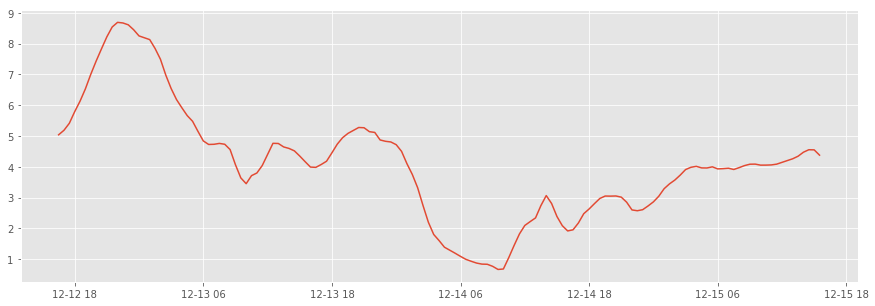

In [8]:
# now we want to plot the data
import matplotlib.pyplot as plt

# Render our plots inline
%matplotlib inline

# Make the graphs a bit prettier
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

# df = df.sort_values('dates', ascending=True)
plt.plot(df['dates'], df['temperature'])
# plt.xticks(rotation='vertical')

In [11]:
# import some stuff to test OWSlib
# https://geopython.github.io/OWSLib/#sos-2-0

from __future__ import (absolute_import, division, print_function)
from owslib.sos import SensorObservationService
from owslib.fes import FilterCapabilities
from owslib.ows import OperationsMetadata
from owslib.crs import Crs
from datetime import datetime
from operator import itemgetter

In [12]:
# tell owslib where to find the Capabilites of our SOS server

getCapabilitiesUrl = mySosUrl + '?service=SOS&request=GetCapabilities&AcceptVersions=2.0.0'
req = urllib.request.Request(url=getCapabilitiesUrl)

with urllib.request.urlopen(req) as response:
    capabilities = response.read()
    soontagaSos = SensorObservationService(None, version='2.0.0', xml=capabilities)


In [13]:
get_obs_params=soontagaSos.get_operation_by_name('GetObservation')

In [14]:
# let's see what is availbale in the server, data offerings etc,
print(get_obs_params.parameters)

{'featureOfInterest': {'values': ['soontaga-station-1']}, 'observedProperty': {'values': ['temperature']}, 'offering': {'values': ['1']}, 'procedure': {'values': ['temperature-sensor']}, 'responseFormat': {'values': ['application/json', 'http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0', 'http://www.opengis.net/om/2.0', 'http://www.opengis.net/waterml-dr/2.0', 'http://www.opengis.net/waterml/2.0']}, 'spatialFilter': {'values': []}, 'temporalFilter': {'values': []}}


In [16]:
from owslib.sos import SensorObservationService
from owslib.swe.observation.sos200 import SOSGetObservationResponse
from owslib.etree import etree

# let's again craft a GetObservation request (without all that bulky XML stuff)
getObsResponse = soontagaSos.get_observation(responseFormat='http://www.opengis.net/om/2.0',
                                             offerings=['1'],
                                             observedProperties=['temperature'],
                                             timeout=60)

# now we let OWSlib do the XML parsing for us, this will take a while
xml_data = etree.fromstring(getObsResponse)
parsed_getObsResponse = SOSGetObservationResponse(xml_data)

# print us some information about the objects we et back
print(type(parsed_getObsResponse))
observationSingle=parsed_getObsResponse.observations[0]
observationSingle.get_result().uom
observationSingle.get_result().value

<class 'owslib.swe.observation.sos200.SOSGetObservationResponse'>


8.270000457763672

In [17]:
# unfortunately OWSlib somehow doesnät give us the dats and times back for outr observation data, 
# so we ad them manually back in here

# number of parsed observation data points
overallCount = len(parsed_getObsResponse.observations)

# we know it's mostly half-hourly, so we stamp them accordingly because we don't get the result value dates back anymore here
timeDeltaEachHalfHour = timedelta(minutes=30)
datetimeBeginOfSeries = dateNow - (overallCount * timeDeltaEachHalfHour)

dateslist2 = []
valueslist2 = []

for obs2 in parsed_getObsResponse.observations:
    dateslist2.append(datetimeBeginOfSeries)
    valueslist2.append(obs2.get_result().value)
    # here we add another half an hour again each time, for each observation we are iterating over
    datetimeBeginOfSeries = datetimeBeginOfSeries + timeDeltaEachHalfHour

# building a pandas dataframe again from our prepared lists
soontaga_data2 = [('dates', dateslist2), ('temperature', valueslist2)]
df2 = pd.DataFrame.from_items(soontaga_data2)

print('----- temperature -----')
print(df2['temperature'].describe())

df2.head()

----- temperature -----
count    31653.000000
mean        10.366331
std          8.739717
min        -20.410000
25%          3.484000
50%          9.410000
75%         17.440001
max         35.480000
Name: temperature, dtype: float64


,dates,temperature
0,2016-02-25 05:34:26.509065,8.270
1,2016-02-25 06:04:26.509065,8.190
2,2016-02-25 06:34:26.509065,7.914
3,2016-02-25 07:04:26.509065,7.726
4,2016-02-25 07:34:26.509065,7.651


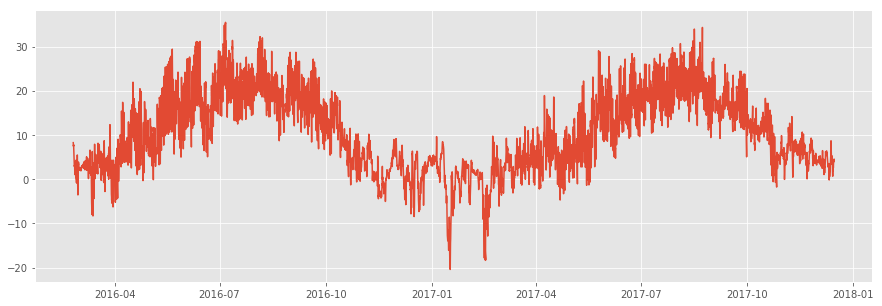

In [19]:
# and plotting again, all the data of the last 1.6 years
plt.rcParams['figure.figsize'] = (15, 5)
# df2 = df2.sort_values('dates', ascending=True)
plt.plot(df2['dates'], df2['temperature'])